## _*Running simulations with noise and measurement error mitigation in Aqua*_

This notebook demonstrates using the [Qiskit Aer](https://qiskit.org/aer) `qasm_simulator` to run a simulation with noise, based on a noise model, in Aqua. This can be useful to investigate behavior under different noise conditions. Aer not only allows you to define your own custom noise model, but also allows a noise model to be easily created based on the properties of a real quantum device. The latter is what this notebook will demonstrate since the goal is to show how to do this in Aqua not how to build custom noise models.

On the other hand, [Qiskit Ignis](https://qiskit.org/ignis) provides a solution to mitigate the measurement error when running on a noise simulation or a real quantum device.

Further information on Qiskit Aer noise model can be found in the online Qiskit Aer documentation [here](https://qiskit.org/documentation/aer/device_noise_simulation.html) as well as in the [Qiskit Aer tutorials](https://github.com/Qiskit/qiskit-tutorials/tree/master/qiskit/aer).

Further information on  measurement error mitigation in Qiskit Ignis can be found in the [Qiskit Ignis tutorial](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/ignis/measurement_error_mitigation.ipynb).

Note: this tutorial requires Qiskit Aer and Qiskit Ignis if you intend to run it. This can be installed using pip if you do not have it installed using `pip install qiskit-aer qiskit-ignis`

In [1]:
import numpy as np
import pylab

from qiskit import Aer, IBMQ
from qiskit.aqua import Operator, QuantumInstance, aqua_globals
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY


Noisy simulation will be demonstrated here with VQE, finding the minimum (ground state) energy of an Hamiltonian, but the technique applies to any quantum algorithm from Aqua.

So for VQE we need a qubit operator as input. Here we will take a set of paulis that were originally computed by qiskit-chemistry, for an H2 molecule, so we can quickly create an Operator.

In [2]:
pauli_dict = {
    'paulis': [{"coeff": {"imag": 0.0, "real": -1.052373245772859}, "label": "II"},
              {"coeff": {"imag": 0.0, "real": 0.39793742484318045}, "label": "ZI"},
              {"coeff": {"imag": 0.0, "real": -0.39793742484318045}, "label": "IZ"},
              {"coeff": {"imag": 0.0, "real": -0.01128010425623538}, "label": "ZZ"},
              {"coeff": {"imag": 0.0, "real": 0.18093119978423156}, "label": "XX"}
              ]
}

qubit_op = Operator.load_from_dict(pauli_dict)
num_qubits = qubit_op.num_qubits
print('Number of qubits: {}'.format(num_qubits))

Number of qubits: 2


As the above problem is still easily tractable classically we can use ExactEigensolver to compute a reference value so we can compare later the results. 

<span style="font-size:0.9em">_(A copy of the operator is used below as what is passed to ExactEigensolver will be converted to matrix form and we want the operator we use later, on the Aer qasm simuator, to be in paulis form.)_</span>

In [3]:
ee = ExactEigensolver(qubit_op.copy())
result = ee.run()
ref = result['energy']
print('Reference value: {}'.format(ref))

Reference value: -1.857275030202381


### Performance *without* noise

First we will run on the simulator without adding noise to see the result. I have created the backend and QuantumInstance, which holds the backend as well as various other run time configuration, which are defaulted here, so it easy to compare when we get to the next section where noise is added. There is no attempt to mitigate noise or anything in this notebook so the latter setup and running of VQE is identical.

In [4]:
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, seed=167, seed_transpiler=167) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

aqua_globals.random_seed = 167
optimizer = SPSA(max_trials=200)
var_form = RY(num_qubits)
vqe = VQE(qubit_op, var_form, optimizer, 'paulis',  callback=store_intermediate_result)
vqe_result = vqe.run(quantum_instance)
print('VQE on Aer qasm simulator (no noise): {}'.format(vqe_result['energy']))
print('Delta from reference: {}'.format(vqe_result['energy']-ref))

VQE on Aer qasm simulator (no noise): -1.8659517701537087
Delta from reference: -0.008676739951327672


We captured the energy values above during the convergence so we can see what went on in the graph below.

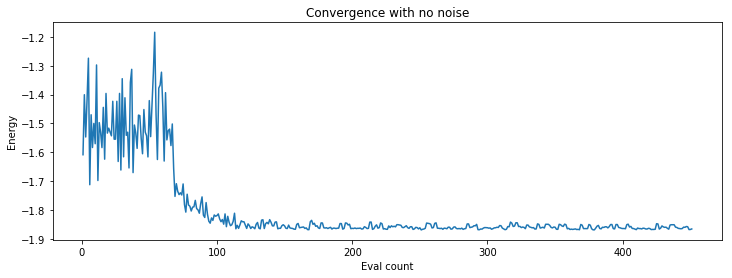

In [5]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise');

### Performance *with* noise

Now we will add noise. Here we will create a noise model for Aer from an actual device. You can create custom noise models with Aer but that goes beyond the scope of this notebook. Links to further information on Aer noise model, for those that may be interested in doing this, were given in instruction above.

First we need to get an actual device backend and from its `configuration` and `properties` we can   setup a coupling map and a noise model to match the device. While we could leave the simulator with the default all to all map, this shows how to set the coupling map too. Note: We can also use this coupling map as the entanglement map for the variational form if we choose.

Note: simulation with noise takes significantly longer than without noise.

In [6]:
from qiskit.providers.aer import noise

IBMQ.load_accounts(hub=None)
device = IBMQ.get_backend('ibmqx4')
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

print(noise_model)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, seed=167, seed_transpiler=167,
                                   noise_model=noise_model,)

counts1 = []
values1 = []
def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)

aqua_globals.random_seed = 167
optimizer = SPSA(max_trials=200)
var_form = RY(num_qubits)
vqe = VQE(qubit_op, var_form, optimizer, 'paulis',  callback=store_intermediate_result1)
vqe_result1 = vqe.run(quantum_instance)
print('VQE on Aer qasm simulator (with noise): {}'.format(vqe_result1['energy']))
print('Delta from reference: {}'.format(vqe_result1['energy']-ref))

NoiseModel:
  Instructions with noise: ['u3', 'cx', 'u2']
  Specific qubit errors: [('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [1, 0]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [3, 2]), ('cx', [3, 4]), ('cx', [4, 2]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
VQE on Aer qasm simulator (with noise): -1.7413471834064167
Delta from reference: 0.11592784679596435


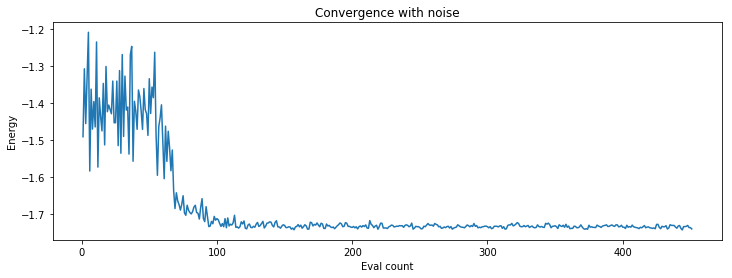

In [7]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts1, values1)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with noise');

### Declarative approach and noise model

Note: if you are running an experiment using the declarative approach, with a dictionary/json, there are keywords in the `backend` section that let you define the noise model based on a device, as well as setup the coupling map too. The basis gate setup, that is shown above, will automatically be done. Here is an example of such a `backend` configuration:
```
    'backend': {   
	  'provider': 'qiskit.Aer',
      'name': 'qasm_simulator',
	  'coupling_map_from_device': 'qiskit.IBMQ:ibmqx4',
      'noise_model': 'qiskit.IBMQ:ibmqx4',
      'shots': 1024
	  },
```

If you call `run_algorithm` and override the `backend` section by explicity supplying a backend instance as a parameter to run_algorithm,  please note that you can provide a QuantumInstance type there instead of BaseBackend. A QuantumInstance allows you to setup and define your own custom noise model and other run time configuration. 

<span style="font-size:0.9em">(Note when a BaseBackend type is supplied to run_algorithm it is internally wrapped into a QuantumInstance, with default values supplied for noise, run time parameters etc., so you do not get the opportunity that way to set a noise model etc. But by explicitly providing a QuantumInstance you can setup these aspects to your choosing.)</span>

### Performance *with* noise and measurement error mitigation

Now we will add method for measurement error mitigation, which increases the fidelity of measurement. Here we choose `CompleteMeasFitter` to mitigate the measurement error. The calibration matrix will be auto-refresh every 30 minute (default value).

Note: simulation with noise takes significantly longer than without noise.

In [8]:
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

quantum_instance = QuantumInstance(backend=backend, seed=167, seed_transpiler=167,
                                   noise_model=noise_model, 
                                   measurement_error_mitigation_cls=CompleteMeasFitter, 
                                   cals_matrix_refresh_period=30)

counts1 = []
values1 = []
def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)

aqua_globals.random_seed = 167
optimizer = SPSA(max_trials=200)
var_form = RY(num_qubits)
vqe = VQE(qubit_op, var_form, optimizer, 'paulis',  callback=store_intermediate_result1)
vqe_result1 = vqe.run(quantum_instance)
print('VQE on Aer qasm simulator (with noise and measurement error mitigation): {}'.format(vqe_result1['energy']))
print('Delta from reference: {}'.format(vqe_result1['energy']-ref))

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.8367010797479668
Delta from reference: 0.020573950454414236


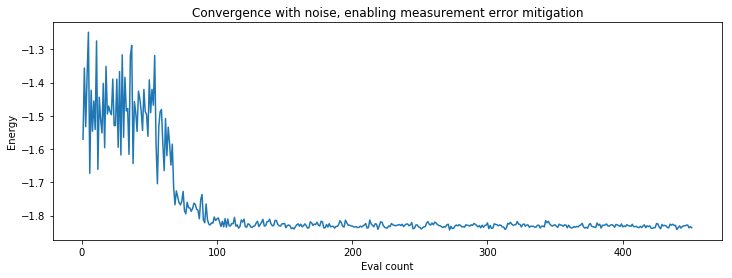

In [9]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts1, values1)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with noise, enabling measurement error mitigation');

### Declarative approach of measurement error mitigation

Note: if you are running an experiment using the declarative approach, with a dictionary/json, there is a keyword `measurement_error_mitigation` in the `problem` section that let you turn ON/OFF the measurement error mitigation, simply set it to `True`.
